An Investigation of Imputation Methods
------------------------------------

https://www.kaggle.com/athi94/investigating-imputation-methods

### Data loading

In [5]:
import numpy as np
import pandas as pd

np.random.seed(7)

train = pd.read_csv('PythonForDataScience/Data/titanic_train.csv')
test = pd.read_csv('PythonForDataScience/Data/titanic_test.csv')

In [6]:
import sys
import warnings

def enforceTypesTitanic(df):
    try:
        df.Survived = df.Survived.astype("category")
    except:
        pass
    df.Pclass = df.Pclass.astype("category", categories=[1, 2, 3], ordered=True)
    df.Sex = df.Sex.astype("category")
    df.Embarked = df.Embarked.astype("category")
    

enforceTypesTitanic(train)
enforceTypesTitanic(test)

e:\datascience\virtualenv\datascience\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
e:\datascience\virtualenv\datascience\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  from ipykernel import kernelapp as app


In [7]:
def naSummary(df):
    return df.isnull().sum()

naSummary(train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
naSummary(test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Verifying Training and Test Sets Similar Distributions

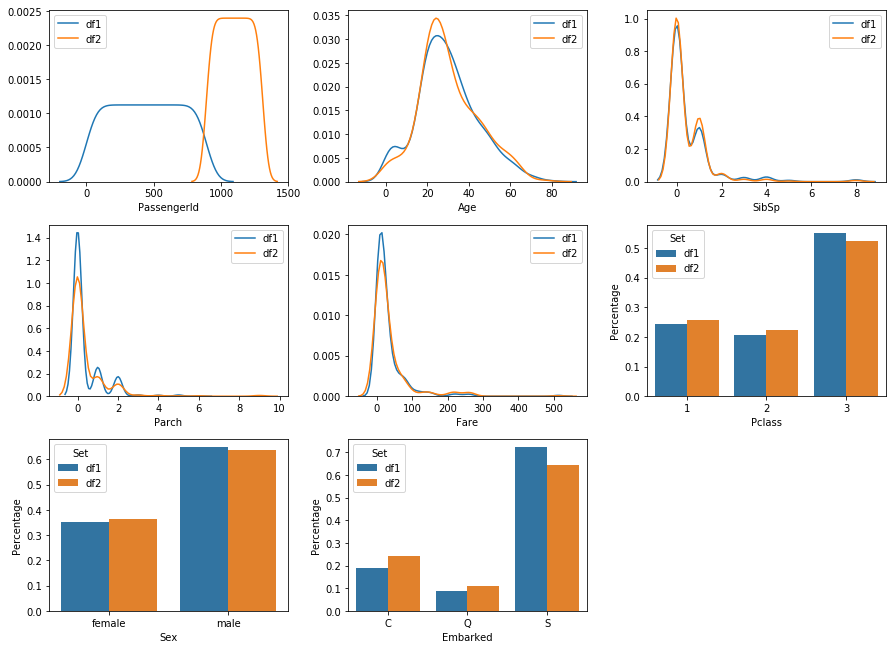

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import itertools

def distComparison(df1, df2):
    a = len(df1.columns)
    if a%2 != 0:
        a += 1
    
    n = np.floor(np.sqrt(a)).astype(np.int64)
    
    while a%n != 0:
        n -= 1
    
    m = (a/n).astype(np.int64)
    coords = list(itertools.product(list(range(m)), list(range(n))))
    
    numerics = df1.select_dtypes(include=[np.number]).columns
    cats = df1.select_dtypes(include=['category']).columns
    
    fig = plt.figure(figsize=(15, 15))
    axes = gs.GridSpec(m, n)
    axes.update(wspace=0.25, hspace=0.25)
    
    for i in range(len(numerics)):
        x, y = coords[i]
        ax = plt.subplot(axes[x, y])
        col = numerics[i]
        sns.kdeplot(df1[col].dropna(), ax=ax, label='df1').set(xlabel=col)
        sns.kdeplot(df2[col].dropna(), ax=ax, label='df2')
        
    for i in range(0, len(cats)):
        x, y = coords[len(numerics)+i]
        ax = plt.subplot(axes[x, y])
        col = cats[i]

        df1_temp = df1[col].value_counts()
        df2_temp = df2[col].value_counts()
        df1_temp = pd.DataFrame({col: df1_temp.index, 'value': df1_temp/len(df1), 'Set': np.repeat('df1', len(df1_temp))})
        df2_temp = pd.DataFrame({col: df2_temp.index, 'value': df2_temp/len(df2), 'Set': np.repeat('df2', len(df2_temp))})

        sns.barplot(x=col, y='value', hue='Set', data=pd.concat([df1_temp, df2_temp]), ax=ax).set(ylabel='Percentage')
        
    
        
distComparison(train.drop('Survived', 1), test)

Create a baseline dataset with no other missing data.

In [11]:
# Refer to Heads or Tails Pytanic kernel for the logic here, https://www.kaggle.com/headsortails/pytanic

train.Embarked = train.Embarked.fillna('C')

train['CabinKnown'] = pd.Categorical((train.Cabin.isnull() == False))
test['CabinKnown'] = pd.Categorical((test.Cabin.isnull() == False))

test.Fare = test.Fare.fillna(8.05)

train = train.drop('Cabin', 1)
test = test.drop('Cabin', 1)

AttributeError: 'DataFrame' object has no attribute 'Cabin'

In [7]:
naSummary(train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
CabinKnown       0
dtype: int64

In [8]:
naSummary(test)

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
CabinKnown      0
dtype: int64

## Missing at Random?

MCAR = missing completely at random.

In essence, if we split the data into two more sets. Data missing and Data present. Then check whether the distribution of the variables in each of these sets is the same, we can assume the data is missing completely at random.

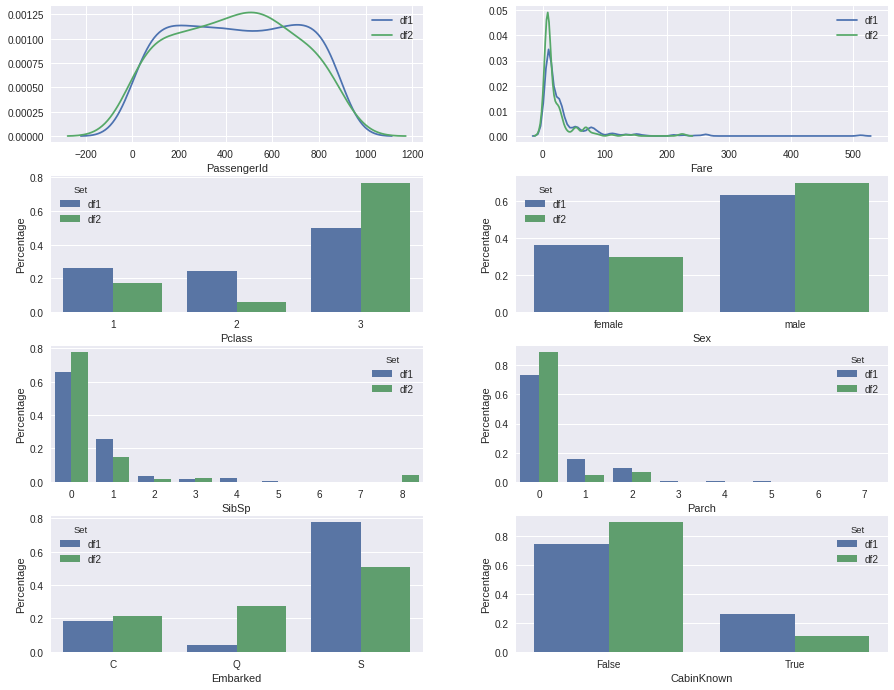

In [9]:
age_present = train.dropna().drop('Age', 1)
age_missing = train[train.isnull().any(axis=1)].drop('Age', 1)

age_present.Parch = age_present.Parch.astype('category', categories=list(range(8)), ordered=True)
age_missing.Parch = age_missing.Parch.astype('category', categories=list(range(8)), ordered=True)

age_present.SibSp = age_present.SibSp.astype('category', categories=list(range(9)), ordered=True)
age_missing.SibSp = age_missing.SibSp.astype('category', categories=list(range(9)), ordered=True)

distComparison(age_present.drop('Survived', 1), age_missing.drop('Survived', 1))

It looks like we can't verify the MCAR assumption. The explanation here seems to be that we're less likely to know the Age of those who died. As evidenced by the much greater proportion of lower class passengers, sharper peak in fare at low levels, and slight skewness towards males.

Most significantly though it seems that those who Embarked at Q have a much higher rate of missing ages.

Note: It would be better to use a more objective measure of MCAR such as Little's test, might do in the future.

## Baseline

Use no `Age` data at all. Standard model will be a Random Forest Classifier with the displayed parameters, all test error estimates are obtained through a 10-fold Cross Validation.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def prepForModel(df):
    new_df = df.copy()
    new_df.Pclass = new_df.Pclass.astype("int")
    new_df.Sex.cat.categories = [0, 1]
    new_df.Sex = new_df.Sex.astype("int")
    new_df.Embarked.cat.categories = [0, 1, 2]
    new_df.Embarked = new_df.Embarked.astype("int")
    new_df.CabinKnown.cat.categories = [0, 1]
    new_df.CabinKnown = new_df.CabinKnown.astype("int")
    return new_df

train_cl = prepForModel(train)
test_cl = prepForModel(test)

Xcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
Ycol = 'Survived'

X = train_cl.loc[:, Xcol]
Y = train_cl.loc[:, Ycol]

Xbase = X
Ybase = Y

rf = RandomForestClassifier(n_estimators=1000,
                           max_depth=None,
                           min_samples_split=10)

baseline_err = cross_val_score(rf, X, Y, cv=10, n_jobs=-1).mean()
print("[BASELINE] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(X), baseline_err))

[BASELINE] Estimated RF Test Error (n = 891, 10-fold CV): 0.8025170241743276


## Deletion

In [11]:
Xdel = train_cl.dropna().loc[:, Xcol + ['Age']]
Ydel = train_cl.dropna().loc[:, Ycol]

deletion_err = cross_val_score(rf, Xdel, Ydel, cv=10, n_jobs=-1).mean()
print("[DELETION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xdel), deletion_err))

[DELETION] Estimated RF Test Error (n = 714, 10-fold CV): 0.8125195618153365


## Mean Substitution

In [12]:
train_cl = prepForModel(train)
train_cl.Age = train_cl.Age.fillna(train_cl.Age.mean(skipna=True))

Xcol = Xcol + ['Age']

Xmean = train_cl.loc[:, Xcol]
Ymean = train_cl.loc[:, Ycol]

mean_err = cross_val_score(rf, Xmean, Ymean, cv=10, n_jobs=-1).mean()
print("[MEAN] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xmean), mean_err))

[MEAN] Estimated RF Test Error (n = 891, 10-fold CV): 0.8216564521620702


## Deterministic and Random Regression

In [13]:
train_cl = prepForModel(train)
train_reg = train_cl.dropna()

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

Xrcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
Yrcol = 'Age'

X_reg = train_reg.loc[:, Xrcol]
Y_reg = train_reg.loc[:, Yrcol]

age_lm = LinearRegression()
age_lm.fit(X_reg, Y_reg)
abs_residuals = np.absolute(Y_reg - age_lm.predict(X_reg))

nan_inds = train_cl.Age.isnull().nonzero()[0]
train_cl2 = train_cl.copy()

for i in nan_inds:
    train_cl.set_value(i, 'Age', age_lm.predict(train_cl.loc[i, Xrcol].values.reshape(1, -1)))

Xreg = train_cl.loc[:, Xcol]
Yreg = train_cl.loc[:, Ycol]
    
reg_err = cross_val_score(rf, Xreg, Yreg, cv=10, n_jobs=-1).mean()
print("[DETERMINISTIC REGRESSION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xreg), reg_err))

for i in nan_inds:
    detreg = age_lm.predict(train_cl2.loc[i, Xrcol].values.reshape(1, -1))
    randreg = np.random.normal(detreg, np.random.choice(abs_residuals))
    train_cl2.set_value(i, 'Age', randreg)
    
Xrandreg = train_cl2.loc[:, Xcol]
Yrandreg = train_cl2.loc[:, Ycol]
    
randreg_err = cross_val_score(rf, Xrandreg, Yrandreg, cv=10, n_jobs=-1).mean()
print("[RANDOM REGRESSION] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xrandreg), randreg_err))

[DETERMINISTIC REGRESSION] Estimated RF Test Error (n = 891, 10-fold CV): 0.8272747134263987
[RANDOM REGRESSION] Estimated RF Test Error (n = 891, 10-fold CV): 0.8272494609011464


## MICE

In [14]:
# from fancyimpute import MICE
# MICE in fancyimputer is deprecated and in place we have the itrative_imputer
# which has some minor changes, but is based on MICE
from fancyimpute import iterative_imputer

train_cl = prepForModel(train)

X = train_cl.loc[:, Xcol]
Y = train_cl.loc[:, Ycol]

Xmice = iterative_imputer(n_imputations=200, impute_type='col', verbose=False).complete(X.as_matrix())
Ymice = Y

mice_err = cross_val_score(rf, Xmice, Y, cv=10, n_jobs=-1).mean()
print("[MICE] Estimated RF Test Error (n = {}, 10-fold CV): {}".format(len(Xmice), mice_err))

[MICE] Estimated RF Test Error (n = 891, 10-fold CV): 0.8227803314039269


## KNN (Standardized Features)

In [15]:
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold

train_cl = prepForModel(train)

Xcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
X = train_cl.loc[:, Xcol + ['Age']]
Y = train_cl.loc[:, Ycol]

def standardize(s):
    return s.sub(s.min()).div((s.max() - s.min()))

Xnorm = X.apply(standardize, axis=0)
kvals = np.linspace(1, 100, 20, dtype='int64')

knn_errs = []
for k in kvals:
    knn_err = []
    Xknn = KNN(k=k, verbose=False).complete(Xnorm)
    knn_err = cross_val_score(rf, Xknn, Y, cv=10, n_jobs=-1).mean()

    knn_errs.append(knn_err)
    print("[KNN] Estimated RF Test Error (n = {}, k = {}, 10-fold CV): {}".format(len(Xknn), k, np.mean(knn_err)))

[KNN] Estimated RF Test Error (n = 891, k = 1, 10-fold CV): 0.8216817046873226
[KNN] Estimated RF Test Error (n = 891, k = 6, 10-fold CV): 0.8261514016570196
[KNN] Estimated RF Test Error (n = 891, k = 11, 10-fold CV): 0.8250275224151629
[KNN] Estimated RF Test Error (n = 891, k = 16, 10-fold CV): 0.8261763704460334
[KNN] Estimated RF Test Error (n = 891, k = 21, 10-fold CV): 0.8272999659516513
[KNN] Estimated RF Test Error (n = 891, k = 27, 10-fold CV): 0.8284235614572693
[KNN] Estimated RF Test Error (n = 891, k = 32, 10-fold CV): 0.8295471569628873
[KNN] Estimated RF Test Error (n = 891, k = 37, 10-fold CV): 0.8284235614572694
[KNN] Estimated RF Test Error (n = 891, k = 42, 10-fold CV): 0.8306707524685052
[KNN] Estimated RF Test Error (n = 891, k = 47, 10-fold CV): 0.8317943479741233
[KNN] Estimated RF Test Error (n = 891, k = 53, 10-fold CV): 0.8306707524685052
[KNN] Estimated RF Test Error (n = 891, k = 58, 10-fold CV): 0.8284235614572693
[KNN] Estimated RF Test Error (n = 891, k 

[BEST KNN] Estimated RF Test Error (n = 891, k = 47, 10-fold CV): 0.8317943479741233


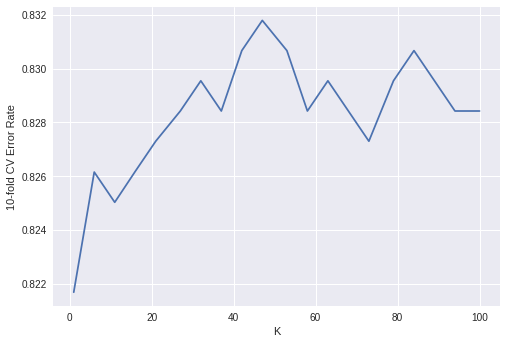

In [16]:
sns.set_style("darkgrid")
_ = plt.plot(kvals, knn_errs)
_ = plt.xlabel('K')
_ = plt.ylabel('10-fold CV Error Rate')

knn_err = max(knn_errs)
k_opt = kvals[knn_errs.index(knn_err)]

Xknn = KNN(k=k_opt, verbose=False).complete(Xnorm)
Yknn = Y

print("[BEST KNN] Estimated RF Test Error (n = {}, k = {}, 10-fold CV): {}".format(len(Xknn), k_opt, np.mean(knn_err)))

# Summary

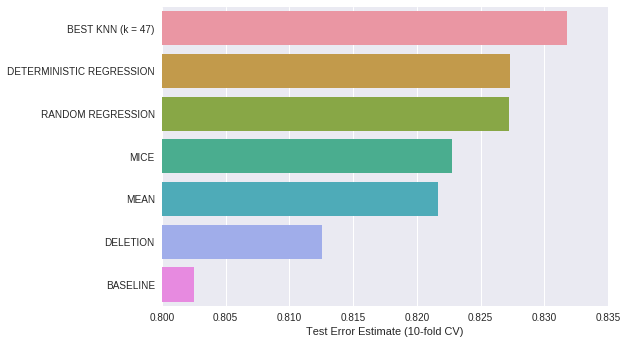

In [17]:
errs = {'BEST KNN (k = {})'.format(k_opt): knn_err,  
        'DETERMINISTIC REGRESSION': reg_err, 
        'RANDOM REGRESSION': randreg_err,
        'MICE': mice_err,
        'MEAN': mean_err,
        'DELETION': deletion_err, 
        'BASELINE': baseline_err}

err_df = pd.DataFrame.from_dict(errs, orient='index')
err_df.index.name = 'Imputation Method'
err_df.reset_index(inplace=True)
err_df.columns = ['Imputation', 'Test Error Estimate (10-fold CV)']

ax = sns.barplot(x=err_df.columns[1], y=err_df.columns[0], order=list.sort(list(errs.values())), data=err_df)
ax.set_xlabel(err_df.columns[1])
ax.set_ylabel('')
_ = plt.xlim(0.8, 0.835)

# Kaggle Double Check

In [18]:
from operator import add

np.random.seed(7)

Xcol = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinKnown']
Ycol = 'Survived'

Xbase.head()
train_cl = prepForModel(train)
test_cl = prepForModel(test)

# Baseline
rf.fit(Xbase, Ybase)
Xbl_test = test_cl.loc[:, Xcol]
bl_preds = rf.predict(Xbl_test)

bl_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': bl_preds})
bl_submit.to_csv("baseline.csv", index=False) # Kaggle: 0.75120

# Mean
rf.fit(Xmean, Ymean)

Xmean_test = test_cl.loc[:, Xcol + ['Age']]
Xmean_test.Age = Xmean_test.Age.fillna(train_cl.Age.mean(skipna=True))
mean_preds = rf.predict(Xmean_test)

mean_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': mean_preds})
mean_submit.to_csv("mean.csv", index=False) # Kaggle: 0.75598

# MICE
rf.fit(Xmice, Ymice)

combine = pd.concat([train.drop('Survived', 1), test])
combine_cl = prepForModel(combine)
Xcomb = combine_cl.loc[:, Xcol + ['Age']]
Xmice_test = iterative_imputer(n_imputations=200, impute_type='col', verbose=False).complete(Xcomb.as_matrix())[len(train):]
mice_preds = rf.predict(Xmice_test)

mice_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': mice_preds})
mice_submit.to_csv("mice.csv", index=False)  # Kaggle: 0.75120


# RANDOM REGRESSION
rf.fit(Xrandreg, Yrandreg)

nan_inds = test_cl.Age.isnull().nonzero()[0]
Xrandreg_test = test_cl.copy()

for i in nan_inds:
    detreg = age_lm.predict(Xrandreg_test.loc[i, Xrcol].values.reshape(1, -1))
    randreg = np.random.normal(detreg, np.random.choice(abs_residuals))
    Xrandreg_test.set_value(i, 'Age', randreg)
    
Xrandreg_test = Xrandreg_test.loc[:, Xcol + ['Age']]
randreg_preds = rf.predict(Xrandreg_test)

randreg_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': randreg_preds})
randreg_submit.to_csv("randreg.csv", index=False)  # Kaggle: 0.75598
    

# DET. REGRESSION
rf.fit(Xreg, Yreg)

nan_inds = test_cl.Age.isnull().nonzero()[0]
Xreg_test = test_cl.copy()

for i in nan_inds:
    Xreg_test.set_value(i, 'Age', age_lm.predict(Xreg_test.loc[i, Xrcol].values.reshape(1, -1)))
    
Xreg_test = Xreg_test.loc[:, Xcol + ['Age']]
reg_preds = rf.predict(Xreg_test)

reg_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': reg_preds})
reg_submit.to_csv("reg.csv", index=False)  # Kaggle: 0.76077

# KNN (k=47)
rf.fit(Xknn, Yknn)

train_plus_testna = pd.concat([train.drop('Survived', 1), test[test.isnull().any(axis=1)]])
train_plus_testna = prepForModel(train_plus_testna)

X = train_plus_testna.loc[:, Xcol + ['Age']]

Xnorm = X.apply(standardize, axis=0)
Xknn_test_age_imps = pd.Series(KNN(k=k_opt, verbose=False).complete(Xnorm)[len(train):, 7])

Xknn_test = test_cl.loc[:, Xcol + ['Age']]
Xknn_test = Xknn_test.apply(standardize, axis=0)

nan_inds = Xknn_test.Age.isnull().nonzero()[0]

for i in range(len(nan_inds)):
    Xknn_test.set_value(nan_inds[i], 'Age', Xknn_test_age_imps[i])
    
knn_preds = rf.predict(Xknn_test)

knn_submit = pd.DataFrame({'PassengerId': test_cl.PassengerId, 'Survived': knn_preds})
knn_submit.to_csv("knn.csv", index=False)  # Kaggle: 0.75120

# Questions

* Why is there such a big discrepancy between CV test error estimate and the Kaggle test error?
* Why do both fancyimpute methods (KNN and MICE) fail quite badly in practice?
* Should I be applying imputations under data from the whole known set (training + test) or just training?

Seems like simple deterministic regression works best on kaggle right now.